In [132]:
import speech_recognition as sr
import subprocess
import multiprocessing as mp
from subprocess import check_call
import os
import random
import string
import pandas as pd
import numpy as np
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVC
import spacy
import re

from xgboost import XGBRegressor, XGBClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,\
    plot_confusion_matrix
import matplotlib.pyplot as plt


csv_name = '../resources/dataset/new_dataset.csv'
csv_processed_name = "../resources/dataset/nlp_model_30k_processed.csv"

In [2]:
data = pd.read_csv(csv_name)
data["Ataque_text"].fillna("não achado", inplace = True) 
data["Resposta_text"].fillna("não achado", inplace = True)
data['Resultado'] = data['Resultado'].apply(lambda x: 1 if x == 'ataque' else 0)
data.drop(['Token', 'Ataque', 'Resposta', 'Round'], axis=1, inplace=True)
data.head()

,Resultado,Ataque_text,Resposta_text
0,0,Pede para sua amada tu tá ligado que tudo dema...,time fraco Mano Lima mano sem nenhum ataque co...
1,1,mano que eu sou sincero com Mc fraco que nem t...,aí Eu começo de aborto e hoje que tá morto sai...
2,0,aí aí aí tá ligado é o aqui é o Ruan é cruel n...,pessoas da hora a sua visão para Mara é difíci...
3,1,pode ficar tranquilo Mário sabe você acabar vo...,aí aí aí tá ligado o meu parceiro que na rima ...
4,1,tá ligado que você é Paulinho eu tivesse até a...,tá ligado mano que eu já chego quando detalhe ...


In [3]:
nlp = spacy.load('pt_core_news_lg')

### Removendo stopwords

In [4]:
def remove_stopwords(row):
    my_doc = nlp(row.Ataque_text)

    token_list = []
    for token in my_doc:
        token_list.append(token.text)
   
    filtered_sentence =[]
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    
    row.Ataque_text = ' '.join([str(elem) for elem in filtered_sentence]) 
    
    my_doc = nlp(row.Resposta_text)

    token_list = []
    for token in my_doc:
        token_list.append(token.text)
   
    filtered_sentence =[]
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    
    row.Resposta_text = ' '.join([str(elem) for elem in filtered_sentence]) 
    
    return row

In [5]:
data = data.apply(remove_stopwords, axis=1)
data.head()

,Resultado,Ataque_text,Resposta_text
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...


### Normalizando

In [6]:
def normalize(row):
    doc = nlp(row.Ataque_text)
    
    lemma_word1 = [] 
    for token in doc:
        lemma_word1.append(token.lemma_)
    lemma_word1
    
    row['Ataque_normalized'] = ' '.join([str(elem) for elem in lemma_word1])
    
    doc = nlp(row.Resposta_text)
    
    lemma_word1 = [] 
    for token in doc:
        lemma_word1.append(token.lemma_)
    lemma_word1
    
    row['Resposta_normalized'] = ' '.join([str(elem) for elem in lemma_word1])
    
    
    return row

In [7]:
data = data.apply(normalize, axis=1)
data.head()

,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...


### Semelhança

In [8]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

def similaridade(row):
    a = nlp(row.Ataque_text).vector
    b = nlp(row.Resposta_text).vector
    row['similaridade'] = cosine_similarity(a, b)
    return row

In [9]:
data = data.apply(similaridade, axis=1)
data.head()

/home/moutinho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized,similaridade
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...,0.729037
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...,0.873968
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...,0.748563
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...,0.702122
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...,0.853304


In [10]:
data["similaridade"].fillna(data.similaridade.mean(), inplace = True) 
data.isnull().sum()

Resultado              0
Ataque_text            0
Resposta_text          0
Ataque_normalized      0
Resposta_normalized    0
similaridade           0
dtype: int64

### Ataque data

In [11]:
def ataque_rows(row):
    row['ataque_len'] = len(row.Ataque_text)
    txt = row.Ataque_text
    row['ataque_ao'] = len(re.findall("ão ", txt)) + len(re.findall("ão$", txt))
    row['ataque_ado'] = len(re.findall("ado ", txt)) + len(re.findall("ado$", txt))
    row['ataque_ade'] = len(re.findall("ade ", txt)) + len(re.findall("ade$", txt))
    row['ataque_em'] = len(re.findall("em ", txt)) + len(re.findall("em$", txt))
    row['ataque_in'] = len(re.findall("in ", txt)) + len(re.findall("in$", txt))
    row['ataque_ar'] = len(re.findall("ar ", txt)) + len(re.findall("ar$", txt))
    row['ataque_er'] = len(re.findall("er ", txt)) + len(re.findall("er$", txt))
    row['ataque_or'] = len(re.findall("or ", txt)) + len(re.findall("or$", txt))
    return row

In [12]:
data = data.apply(ataque_rows, axis=1)
data.head()

,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,ataque_em,ataque_in,ataque_ar,ataque_er,ataque_or
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...,0.729037,190,1,1,0,0,0,1,0,0
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...,0.873968,210,0,0,0,0,0,1,0,0
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...,0.748563,152,1,0,0,0,0,1,0,0
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...,0.702122,176,0,0,0,0,0,3,0,0
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...,0.853304,230,0,2,0,0,0,0,0,0


### Resposta data

In [13]:
def ataque_rows(row):
    row['resposta_len'] = len(row.Resposta_text)
    txt = row.Resposta_text
    row['resposta_ao'] = len(re.findall("ão ", txt)) + len(re.findall("ão$", txt))
    row['resposta_ado'] = len(re.findall("ado ", txt)) + len(re.findall("ado$", txt))
    row['resposta_ade'] = len(re.findall("ade ", txt)) + len(re.findall("ade$", txt))
    row['resposta_em'] = len(re.findall("em ", txt)) + len(re.findall("em$", txt))
    row['resposta_in'] = len(re.findall("in ", txt)) + len(re.findall("in$", txt))
    row['resposta_ar'] = len(re.findall("ar ", txt)) + len(re.findall("ar$", txt))
    row['resposta_er'] = len(re.findall("er ", txt)) + len(re.findall("er$", txt))
    row['resposta_or'] = len(re.findall("or ", txt)) + len(re.findall("or$", txt))
    return row

In [14]:
data = data.apply(ataque_rows, axis=1)
data.head()

,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,...,ataque_or,resposta_len,resposta_ao,resposta_ado,resposta_ade,resposta_em,resposta_in,resposta_ar,resposta_er,resposta_or
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...,0.729037,190,1,1,0,...,0,267,1,0,0,0,0,0,0,0
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...,0.873968,210,0,0,0,...,0,268,0,0,0,0,0,1,0,1
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...,0.748563,152,1,0,0,...,0,178,1,0,0,0,0,8,0,0
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...,0.702122,176,0,0,0,...,0,213,0,0,0,0,0,0,0,0
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...,0.853304,230,0,2,0,...,0,144,0,0,0,0,0,0,0,0


In [25]:
data.to_csv(csv_processed_name)

### NLP model

In [15]:
X = data.copy()
y = data.Resultado.copy()
X.drop(['Resultado'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

In [16]:
with nlp.disable_pipes():
    ataque_vectors_train = np.array([nlp(text).vector for text in X_train.Ataque_normalized])
    ataque_vectors_test = np.array([nlp(text).vector for text in X_test.Ataque_normalized])
    resposta_vectors_train = np.array([nlp(text).vector for text in X_train.Resposta_normalized])
    resposta_vectors_test = np.array([nlp(text).vector for text in X_test.Resposta_normalized])

In [17]:
model_ataque = RandomForestRegressor(random_state=1)
# Fit the model
model_ataque.fit(ataque_vectors_train,y_train)

model_ataque_preds_traine = model_ataque.predict(ataque_vectors_train)
model_ataque_preds = model_ataque.predict(ataque_vectors_test)
print('treino: ', mean_absolute_error(y_train, model_ataque_preds_traine))
print('teste: ', mean_absolute_error(y_test, model_ataque_preds))

treino:  0.18231773143309093
teste:  0.4847236065526045


In [18]:
model_resposta = RandomForestRegressor(random_state=1)
# Fit the model
model_resposta.fit(resposta_vectors_train,y_train)

model_resposta_preds_train = model_resposta.predict(resposta_vectors_train)
model_resposta_preds = model_resposta.predict(resposta_vectors_test)
print('treino: ', mean_absolute_error(y_train, model_resposta_preds_train))
print('teste: ', mean_absolute_error(y_test, model_resposta_preds))

treino:  0.17886750874374968
teste:  0.47468614585294766


### Table model

In [19]:
X = data.copy()
X.drop(['Ataque_text', 'Resposta_text', 'Ataque_normalized', 'Resposta_normalized'], axis=1, inplace=True)
y = data.Resultado.copy()
X.drop(['Resultado'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

X_train.head()

,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,ataque_em,ataque_in,ataque_ar,ataque_er,ataque_or,resposta_len,resposta_ao,resposta_ado,resposta_ade,resposta_em,resposta_in,resposta_ar,resposta_er,resposta_or
7077,0.701008,292,2,3,0,0,0,4,0,0,299,1,1,2,0,0,3,0,0
14434,0.884509,248,1,1,0,0,0,2,0,0,238,3,1,0,0,0,4,1,1
11423,0.676540,241,1,0,0,0,0,1,0,0,194,2,2,0,0,1,5,0,0
14868,0.699633,286,5,1,0,1,0,1,0,0,284,1,0,0,0,0,6,1,0
4429,0.906294,235,1,2,0,0,0,1,1,0,201,2,0,0,0,0,3,2,1


In [20]:
model_table = RandomForestRegressor(random_state=1, n_estimators= 80)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  99.99605070889776
teste:  60.227452219238664


In [22]:
model_table = XGBRegressor(n_estimators=30)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  68.8479917854745
teste:  62.233454430579684


## Text Parser

In [17]:
processed_data_df = pd.read_csv(csv_processed_name, index_col=0)
processed_data_df.head()

,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,...,ataque_or,resposta_len,resposta_ao,resposta_ado,resposta_ade,resposta_em,resposta_in,resposta_ar,resposta_er,resposta_or
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...,0.729037,190,1,1,0,...,0,267,1,0,0,0,0,0,0,0
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...,0.873968,210,0,0,0,...,0,268,0,0,0,0,0,1,0,1
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...,0.748563,152,1,0,0,...,0,178,1,0,0,0,0,8,0,0
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...,0.702122,176,0,0,0,...,0,213,0,0,0,0,0,0,0,0
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...,0.853304,230,0,2,0,...,0,144,0,0,0,0,0,0,0,0


CountVectorizer generates weights relative to how many times a word or a combination or words(ngrams) appear no matter how big is the document. While TfidfTransformer makes it proportional to the size of the document. The parm "use_idf" highlights the less frequents ones because they can be more informative than other words that appear a lot.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

''' Best parameter using GridSearch (CV score=0.535): 
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
Those were obtained on the next code block.
'''
count_vectorizer_ataque = CountVectorizer()
count_vectorizer_resposta = CountVectorizer()
tfidf_transformer_ataque = TfidfTransformer()
tfidf_transformer_resposta = TfidfTransformer()

''' Let's transform the lemmatized documents into count vectors '''
count_vectors_ataque = count_vectorizer_ataque.fit_transform(
    processed_data_df['Ataque_normalized'].values.astype('U'))
count_vectors_resposta = count_vectorizer_resposta.fit_transform(
    processed_data_df['Resposta_normalized'].values.astype('U'))

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors_ataque = tfidf_transformer_ataque.fit_transform(count_vectors_ataque)
frequency_vectors_resposta = tfidf_transformer_resposta.fit_transform(count_vectors_resposta)

### Optimizando termos ataque

In [19]:
term_codes_ataque = []
for code, value in enumerate(count_vectors_ataque.toarray()[0]):
    if value:
        term_codes_ataque.append(code)

frequency_values_ataque = []
for code, value in enumerate(frequency_vectors_ataque.toarray()[0]):
    if code in term_codes_ataque:
        frequency_values_ataque.append(str(round(value*100, 2))+"%")

terms_ataque = []
for code in term_codes_ataque:
    terms_ataque.append(count_vectorizer_ataque.get_feature_names()[code])

features_frequencies_df_ataque = pd.DataFrame({'Feature Name': terms_ataque, 'Feature Code': term_codes_ataque, 'Feature Percentual Frequency': frequency_values_ataque})
features_frequencies_df_ataque

,Feature Name,Feature Code,Feature Percentual Frequency
0,ajudar,910,14.47%
1,amar,1237,13.66%
2,assistir,1993,15.38%
3,atiçar,2098,27.3%
4,baunilha,2727,29.2%
5,camarote,3982,29.2%
6,chegar,4823,5.53%
7,dar,6584,9.43%
8,explicar,9275,24.99%
9,fito,9883,12.78%


Todos as partes de grindsearching em seguida são hiperparametrizações - não precisa ser feito mais de uma vez

In [20]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')
    
    ''' Those are all the params values that will be tested.'''
    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}
    
    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(processed_data_df['Ataque_normalized'].values.astype('U'), processed_data_df['Resultado'])
    results = gs.cv_results_
    print(gs.best_params_)

### Optimizando termos defesa

In [21]:
term_codes_resposta = []
for code, value in enumerate(count_vectors_resposta.toarray()[0]):
    if value:
        term_codes_resposta.append(code)

frequency_values_resposta = []
for code, value in enumerate(frequency_vectors_resposta.toarray()[0]):
    if code in term_codes_resposta:
        frequency_values_resposta.append(str(round(value*100, 2))+"%")

terms_resposta = []
for code in term_codes_resposta:
    terms_resposta.append(count_vectorizer_resposta.get_feature_names()[code])

features_frequencies_df_resposta = pd.DataFrame({'Feature Name': terms_resposta, 'Feature Code': term_codes_resposta, 'Feature Percentual Frequency': frequency_values_resposta})
features_frequencies_df_resposta

,Feature Name,Feature Code,Feature Percentual Frequency
0,atacar,1946,9.62%
1,bagulho,2319,19.44%
2,camarada,3827,30.18%
3,causar,4342,13.1%
4,chegar,4671,18.45%
5,complicar,5359,18.51%
6,destreza,7097,23.76%
7,fraco,9948,8.62%
8,frank,9985,24.36%
9,gatilho,10403,20.96%


In [22]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')
    
    ''' Those are all the params values that will be tested.'''
    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}
    
    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(processed_data_df['Resposta_normalized'].values.astype('U'), processed_data_df['Resultado'])
    results = gs.cv_results_
    print(gs.best_params_)

## Topic Modeling

#### Topics ataque

In [27]:
''' Creating and fit the LDA model using the count_vectors generated before '''
lda_ataque = LDA(n_jobs=-1)
topics_vectors_ataque = lda_ataque.fit_transform(count_vectors_ataque)

In [28]:
LDAvis_prepared = sklearn_lda.prepare(lda_ataque, count_vectors_ataque, count_vectorizer_ataque)

pyLDAvis.display(LDAvis_prepared)

In [29]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer(
        max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
    search_tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
    lda = LDA(n_jobs=-1)
    gnb = GaussianNB()

    search_params = {
        'lda__max_iter': [20],
        'lda__n_components': [60]
    } 

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('lda', lda),
        ('gnb', gnb)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(processed_data_df['Ataque_normalized'].values.astype('U'), processed_data_df['Resultado'])
    print(gs.best_params_)

#### Topics resposta

In [30]:
''' Creating and fit the LDA model using the count_vectors generated before '''
lda_resposta = LDA(n_jobs=-1)
topics_vectors_resposta = lda_resposta.fit_transform(count_vectors_resposta)

In [31]:
LDAvis_prepared = sklearn_lda.prepare(lda_resposta, count_vectors_resposta, count_vectorizer_resposta)

pyLDAvis.display(LDAvis_prepared)

In [32]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer(
        max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
    search_tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
    lda = LDA(n_jobs=-1)
    gnb = GaussianNB()

    search_params = {
        'lda__max_iter': [20],
        'lda__n_components': [60]
    } 

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('lda', lda),
        ('gnb', gnb)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(processed_data_df['Resposta_normalized'].values.astype('U'), processed_data_df['Resultado'])
    print(gs.best_params_)

### Storing topics scores as variables

#### Ataque

In [64]:
num_topics = 10

''' We'll need the same number of lists as the number of topics  '''
topics_scores = [[] for i in range(num_topics)]

''' We then extract each row score to different columns '''
for doc_topics in topics_vectors_ataque:
    for i in range(0, num_topics):
        if doc_topics[i]:
            topics_scores[i].append(doc_topics[i])
        else: 
            topics_scores[i].append(0)


''' And store then in the data as variables for their respectives rows'''
topics_skl_columns = []
for i in range(0, num_topics):
    column_name = 'TOPIC_SKL_ATK' + str(i)
    topics_skl_columns.append(column_name)
    processed_data_df[column_name] = topics_scores[i]

print(processed_data_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31652 entries, 0 to 31651
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Resultado            31652 non-null  int64  
 1   Ataque_text          31639 non-null  object 
 2   Resposta_text        31649 non-null  object 
 3   Ataque_normalized    31639 non-null  object 
 4   Resposta_normalized  31649 non-null  object 
 5   similaridade         31652 non-null  float64
 6   ataque_len           31652 non-null  int64  
 7   ataque_ao            31652 non-null  int64  
 8   ataque_ado           31652 non-null  int64  
 9   ataque_ade           31652 non-null  int64  
 10  ataque_em            31652 non-null  int64  
 11  ataque_in            31652 non-null  int64  
 12  ataque_ar            31652 non-null  int64  
 13  ataque_er            31652 non-null  int64  
 14  ataque_or            31652 non-null  int64  
 15  resposta_len         31652 non-null 

#### Resposta

In [65]:
num_topics = 10

''' We'll need the same number of lists as the number of topics  '''
topics_scores = [[] for i in range(num_topics)]

''' We then extract each row score to different columns '''
for doc_topics in topics_vectors_resposta:
    for i in range(0, num_topics):
        if doc_topics[i]:
            topics_scores[i].append(doc_topics[i])
        else: 
            topics_scores[i].append(0)


''' And store then in the data as variables for their respectives rows'''
for i in range(0, num_topics):
    column_name = 'TOPIC_SKL_RES' + str(i)
    topics_skl_columns.append(column_name)
    processed_data_df[column_name] = topics_scores[i]

print(processed_data_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31652 entries, 0 to 31651
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Resultado            31652 non-null  int64  
 1   Ataque_text          31639 non-null  object 
 2   Resposta_text        31649 non-null  object 
 3   Ataque_normalized    31639 non-null  object 
 4   Resposta_normalized  31649 non-null  object 
 5   similaridade         31652 non-null  float64
 6   ataque_len           31652 non-null  int64  
 7   ataque_ao            31652 non-null  int64  
 8   ataque_ado           31652 non-null  int64  
 9   ataque_ade           31652 non-null  int64  
 10  ataque_em            31652 non-null  int64  
 11  ataque_in            31652 non-null  int64  
 12  ataque_ar            31652 non-null  int64  
 13  ataque_er            31652 non-null  int64  
 14  ataque_or            31652 non-null  int64  
 15  resposta_len         31652 non-null 

In [66]:
processed_data_df

,Resultado,Ataque_text,Resposta_text,Ataque_normalized,Resposta_normalized,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,...,TOPIC_SKL_RES0,TOPIC_SKL_RES1,TOPIC_SKL_RES2,TOPIC_SKL_RES3,TOPIC_SKL_RES4,TOPIC_SKL_RES5,TOPIC_SKL_RES6,TOPIC_SKL_RES7,TOPIC_SKL_RES8,TOPIC_SKL_RES9
0,0,Pede amada tá ruim melhorar chego fita si assi...,time fraco Mano Lima mano nenhum ataque vou re...,Pede amar tá ruim melhorar chegar fito si assi...,time fraco Mano Lima manir nenhum atacar ir re...,0.729037,190,1,1,0,...,0.002440,0.002440,0.002440,0.761923,0.201394,0.002440,0.002440,0.019605,0.002440,0.002440
1,1,mano sincero Mc fraco ganho 2 a 0 tá mano comu...,começo aborto e hoje tá morto sai moleque Deix...,manir sincero Mc fraco ganhar 2 o 0 tá manir c...,comedir abortar e hoje tá morto sair moleque D...,0.873968,210,0,0,0,...,0.002223,0.002223,0.979995,0.002223,0.002223,0.002223,0.002223,0.002223,0.002223,0.002223
2,0,tá o o Ruan cruel ima aguenta vou quebrando te...,pessoas hora a visão Mara difícil lidar Espero...,tá o o Ruan cruel imo aguentar ir quebrar teme...,pessoa horar o visão Mara difícil lidar Espero...,0.748563,152,1,0,0,...,0.004001,0.687691,0.004001,0.004001,0.280301,0.004001,0.004001,0.004001,0.004001,0.004001
3,1,ficar tranquilo Mário acabar tenta tenta vou b...,tá o parceiro rima pega mandou o dicionário tr...,ficar tranquilo Mário acabar tentar tentar ir ...,tá o parceiro rimar pego mandar o dicionário t...,0.702122,176,0,0,0,...,0.003334,0.003335,0.003335,0.003334,0.003334,0.003334,0.003334,0.003334,0.969993,0.003334
4,1,tá Paulinho tivesse arrumando o tá mano Paulin...,tá mano chego detalhe verso tá afim mano torna...,tá Paulinho ter arrumar o tá manir Paulinho 12...,tá manir chegar detalhar versar tá afim manir ...,0.853304,230,0,2,0,...,0.003847,0.003847,0.003847,0.540651,0.428573,0.003847,0.003847,0.003847,0.003847,0.003847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31647,0,mano calor escola Daí professor a rima vergonh...,entendi direito o camaradinha mano piadinha fa...,manir calor escola Daí professor o rimar vergo...,entender direito o camarada manir piada falir ...,0.779687,229,4,0,0,...,0.004002,0.004001,0.004001,0.004001,0.426742,0.113873,0.431377,0.004000,0.004001,0.004001
31648,0,achado,satisfação OLX tá ouvindo absurdo apanhar fing...,achar,satisfação OLX tá ouvir absurdo apanhar fingir...,0.342708,6,0,1,0,...,0.003573,0.003573,0.774095,0.003572,0.003572,0.197325,0.003572,0.003573,0.003573,0.003572
31649,1,satisfação e insatisfação divulgar,achado,satisfação e insatisfação divulgar,achar,0.023300,34,2,0,0,...,0.050001,0.050001,0.050001,0.050001,0.050001,0.050002,0.549988,0.050002,0.050002,0.050002
31650,1,Ah Ah fiz OLX DVD OLX entende pinto unges tô f...,Estação juiz agitação Bienal,Ah Ah fazer OLX DVD OLX entender pintar ungir ...,Estação juiz agitação Bienal,0.001578,311,2,3,0,...,0.020003,0.020005,0.020006,0.020004,0.020002,0.020003,0.219982,0.619994,0.020001,0.020001


In [67]:
topics_skl_columns

['TOPIC_SKL_ATK0',
 'TOPIC_SKL_ATK1',
 'TOPIC_SKL_ATK2',
 'TOPIC_SKL_ATK3',
 'TOPIC_SKL_ATK4',
 'TOPIC_SKL_ATK5',
 'TOPIC_SKL_ATK6',
 'TOPIC_SKL_ATK7',
 'TOPIC_SKL_ATK8',
 'TOPIC_SKL_ATK9',
 'TOPIC_SKL_RES0',
 'TOPIC_SKL_RES1',
 'TOPIC_SKL_RES2',
 'TOPIC_SKL_RES3',
 'TOPIC_SKL_RES4',
 'TOPIC_SKL_RES5',
 'TOPIC_SKL_RES6',
 'TOPIC_SKL_RES7',
 'TOPIC_SKL_RES8',
 'TOPIC_SKL_RES9']

## Model Train and Cross-Validation After TOPIC MODELING

- Cross validation with all features

In [96]:
classifier = XGBClassifier(n_estimators=60)
TARGET_VARIABLE = 'Resultado'
features = topics_skl_columns + ['similaridade','ataque_len','ataque_ao','ataque_ado','ataque_ade',
                                 'ataque_em','ataque_in','ataque_ar','ataque_er','ataque_or','resposta_len',
                                 'resposta_ao','resposta_ado','resposta_ade','resposta_em','resposta_in',
                                 'resposta_ar','resposta_er','resposta_or']

pipeline_simple = Pipeline([
    ('classifier', classifier)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    processed_data_df[features],
    processed_data_df[TARGET_VARIABLE], cv=5)
print(scores)
print("Mean accuracy for explicit pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.60954036 0.60622335 0.61200632 0.60331754 0.59921011]
Mean accuracy for explicit pipeline:  60.61%


In [97]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)
TARGET_VARIABLE = 'Resultado'
features = topics_skl_columns + ['similaridade','ataque_len','ataque_ao','ataque_ado','ataque_ade',
                                 'ataque_em','ataque_in','ataque_ar','ataque_er','ataque_or','resposta_len',
                                 'resposta_ao','resposta_ado','resposta_ade','resposta_em','resposta_in',
                                 'resposta_ar','resposta_er','resposta_or']

pipeline_simple = Pipeline([
    ('classifier', classifier)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    processed_data_df[features],
    processed_data_df[TARGET_VARIABLE], cv=5)
print(scores)
print("Mean accuracy for explicit pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.60890855 0.62122887 0.61342812 0.61532385 0.60774092]
Mean accuracy for explicit pipeline:  61.33%


- Cross validation only with skl topics

In [98]:
classifier = XGBClassifier(n_estimators=60)
TARGET_VARIABLE = 'Resultado'
features = topics_skl_columns

pipeline_simple = Pipeline([
    ('classifier', classifier)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    processed_data_df[features],
    processed_data_df[TARGET_VARIABLE], cv=5)
print(scores)
print("Mean accuracy for explicit pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.60180066 0.60559153 0.61374408 0.61390205 0.59889415]
Mean accuracy for explicit pipeline:  60.68%


In [99]:
classifier =  RandomForestClassifier(max_depth=4, random_state=0)
TARGET_VARIABLE = 'Resultado'
features = topics_skl_columns

pipeline_simple = Pipeline([
    ('classifier', classifier)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    processed_data_df[features],
    processed_data_df[TARGET_VARIABLE], cv=5)
print(scores)
print("Mean accuracy for explicit pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.60843469 0.61649029 0.61137441 0.61232227 0.60505529]
Mean accuracy for explicit pipeline:  61.07%


- Just modeling with all features

In [100]:
X = processed_data_df.copy()
X.drop(['Ataque_text', 'Resposta_text', 'Ataque_normalized', 'Resposta_normalized'], axis=1, inplace=True)
y = processed_data_df.Resultado.copy()
X.drop(['Resultado'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

X_train.head()

,similaridade,ataque_len,ataque_ao,ataque_ado,ataque_ade,ataque_em,ataque_in,ataque_ar,ataque_er,ataque_or,...,TOPIC_SKL_RES0,TOPIC_SKL_RES1,TOPIC_SKL_RES2,TOPIC_SKL_RES3,TOPIC_SKL_RES4,TOPIC_SKL_RES5,TOPIC_SKL_RES6,TOPIC_SKL_RES7,TOPIC_SKL_RES8,TOPIC_SKL_RES9
7077,0.701008,292,2,3,0,0,0,4,0,0,...,0.161080,0.002128,0.002128,0.002128,0.002128,0.500857,0.002128,0.002128,0.323165,0.002128
14434,0.884509,248,1,1,0,0,0,2,0,0,...,0.002703,0.002704,0.002703,0.892401,0.085972,0.002703,0.002703,0.002703,0.002703,0.002703
11423,0.676540,241,1,0,0,0,0,1,0,0,...,0.003705,0.003705,0.411548,0.193485,0.369034,0.003705,0.003704,0.003704,0.003705,0.003705
14868,0.699633,286,5,1,0,1,0,1,0,0,...,0.002174,0.002175,0.002175,0.002175,0.002174,0.980430,0.002174,0.002174,0.002174,0.002174
4429,0.906294,235,1,2,0,0,0,1,1,0,...,0.002942,0.114518,0.861948,0.002942,0.002942,0.002942,0.002942,0.002942,0.002942,0.002942


In [101]:
model_table = XGBClassifier(n_estimators=60)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  76.71892895225308
teste:  61.854367398515244


In [102]:
model_table = RandomForestClassifier(max_depth=4, random_state=0)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  61.81825362347458
teste:  61.7911862265045


In [103]:
model_table = SGDClassifier()
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  43.64756526203546
teste:  42.315589954193655


- Just modeling only with skl features

In [104]:
X = processed_data_df.copy()
X = X[topics_skl_columns]
y = processed_data_df.Resultado.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

X_train.head()

,TOPIC_SKL_ATK0,TOPIC_SKL_ATK1,TOPIC_SKL_ATK2,TOPIC_SKL_ATK3,TOPIC_SKL_ATK4,TOPIC_SKL_ATK5,TOPIC_SKL_ATK6,TOPIC_SKL_ATK7,TOPIC_SKL_ATK8,TOPIC_SKL_ATK9,TOPIC_SKL_RES0,TOPIC_SKL_RES1,TOPIC_SKL_RES2,TOPIC_SKL_RES3,TOPIC_SKL_RES4,TOPIC_SKL_RES5,TOPIC_SKL_RES6,TOPIC_SKL_RES7,TOPIC_SKL_RES8,TOPIC_SKL_RES9
7077,0.215974,0.002500,0.002501,0.002501,0.205060,0.561463,0.002501,0.002500,0.002500,0.002500,0.161080,0.002128,0.002128,0.002128,0.002128,0.500857,0.002128,0.002128,0.323165,0.002128
14434,0.002633,0.002632,0.002632,0.002632,0.002632,0.002633,0.002632,0.387610,0.591332,0.002632,0.002703,0.002704,0.002703,0.892401,0.085972,0.002703,0.002703,0.002703,0.002703,0.002703
11423,0.002858,0.002858,0.002858,0.002858,0.435878,0.002858,0.366126,0.002858,0.177992,0.002858,0.003705,0.003705,0.411548,0.193485,0.369034,0.003705,0.003704,0.003704,0.003705,0.003705
14868,0.002501,0.002501,0.041864,0.002501,0.002500,0.280132,0.660500,0.002500,0.002500,0.002501,0.002174,0.002175,0.002175,0.002175,0.002174,0.980430,0.002174,0.002174,0.002174,0.002174
4429,0.002273,0.002273,0.002273,0.002274,0.002273,0.740485,0.241329,0.002273,0.002273,0.002273,0.002942,0.114518,0.861948,0.002942,0.002942,0.002942,0.002942,0.002942,0.002942,0.002942


In [105]:
model_table = XGBClassifier(n_estimators=60)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  75.3801192685913
teste:  61.03301216237561


In [106]:
model_table = RandomForestClassifier(max_depth=4, random_state=0)
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  61.48651317088583
teste:  61.22255567840784


In [107]:
model_table = SGDClassifier()
# Fit the model
model_table.fit(X_train,y_train)

model_table_preds_train = model_table.predict(X_train)
model_table_preds = model_table.predict(X_test)
print('treino: ', (1 - mean_absolute_error(y_train, np.round(model_table_preds_train, 0))) * 100)
print('teste: ', (1 - mean_absolute_error(y_test, np.round(model_table_preds, 0))) * 100)

treino:  56.44326843331622
teste:  57.76338651081978


### Features Vectors Inversed Frequencies

- PS: Pipeline seems odly fast

In [108]:
count_vectorizer = CountVectorizer(max_features=None)
tfidf_transformer = TfidfTransformer()
clf = SGDClassifier()

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

scores = cross_val_score(
    pipeline,
    processed_data_df['Ataque_normalized'].values.astype('U'),
    processed_data_df[TARGET_VARIABLE], cv=10)
print(scores)
print("Mean accuracy for pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.58085913 0.58622868 0.57061611 0.5535545  0.56492891 0.57251185
 0.56587678 0.56650869 0.56556082 0.5699842 ]
Mean accuracy for pipeline:  56.97%


In [109]:
count_vectorizer = CountVectorizer(max_features=None)
tfidf_transformer = TfidfTransformer()
clf = SGDClassifier()

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

scores = cross_val_score(
    pipeline,
    processed_data_df['Resposta_normalized'].values.astype('U'),
    processed_data_df[TARGET_VARIABLE], cv=10)
print(scores)
print("Mean accuracy for pipeline: ", str(round(scores.mean()*100,2))+"%")

[0.56664561 0.60644346 0.5835703  0.59368088 0.58609795 0.59589258
 0.58515008 0.59115324 0.58325434 0.57914692]
Mean accuracy for pipeline:  58.71%


## Model Comparison

In [127]:
X = processed_data_df.copy()
features = topics_skl_columns + ['similaridade','ataque_len','ataque_ao','ataque_ado','ataque_ade',
                                 'ataque_em','ataque_in','ataque_ar','ataque_er','ataque_or','resposta_len',
                                 'resposta_ao','resposta_ado','resposta_ade','resposta_em','resposta_in',
                                 'resposta_ar','resposta_er','resposta_or']
X = X[features]
y = processed_data_df.Resultado.copy()

''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

''' First we need to instantiate some components again to avoid overfit'''
classifier = RandomForestClassifier(max_depth=4, random_state=0)

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('classifier', classifier)
])

train1 = X_train
labelsTrain1 = y_train
test1 = X_test
labelsTest1 = y_test

"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=['0', '1']))

accuracy: 0.6183857210551256
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      3656
           1       0.59      0.31      0.41      2675

    accuracy                           0.62      6331
   macro avg       0.61      0.58      0.56      6331
weighted avg       0.61      0.62      0.59      6331



## Confusion Matrix

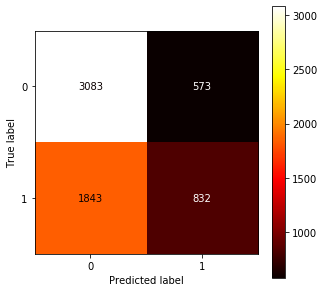

In [131]:
fig = plt.figure(figsize=(5, 5))
axes = plt.axes()

plot_confusion_matrix(pipeline, test1, labelsTest1, cmap='hot', ax=axes)